In [ ]:
import torch
a = torch.tensor([[[0.1,0.2],[0.5,0.6],[0.5,0.6],[0.5,0.6]],[[0.3,0.4],[0.5,0.8],[0.2,0.3],[0.4,0.5],]])
print(a)
# print(a.sum(dim=0).sum(dim=1))

# b = torch.cumsum(a, dim=1)
# print(b)
# print(b[:,:-1])

# c = torch.cat([torch.ones_like(a[:, :1]), 1.0 - b[:,:-1]], dim=1)

cdf = torch.cumsum(a, dim=1)
print(cdf)
c = torch.cat(
    [torch.ones_like(a[:, :1, :]),
     1.0 - cdf[:, :-1, :]],
    dim=1
)

print(c)


tensor([[[0.1000, 0.2000],
         [0.5000, 0.6000],
         [0.5000, 0.6000],
         [0.5000, 0.6000]],

        [[0.3000, 0.4000],
         [0.5000, 0.8000],
         [0.2000, 0.3000],
         [0.4000, 0.5000]]])
tensor([[[0.1000, 0.2000],
         [0.6000, 0.8000],
         [1.1000, 1.4000],
         [1.6000, 2.0000]],

        [[0.3000, 0.4000],
         [0.8000, 1.2000],
         [1.0000, 1.5000],
         [1.4000, 2.0000]]])
tensor([[[ 1.0000,  1.0000],
         [ 0.9000,  0.8000],
         [ 0.4000,  0.2000],
         [-0.1000, -0.4000]],

        [[ 1.0000,  1.0000],
         [ 0.7000,  0.6000],
         [ 0.2000, -0.2000],
         [ 0.0000, -0.5000]]])


## LAB

In [3]:
import pathlib      
from tqdm import tqdm
import meds_reader
import femr.stat_utils
a = femr.stat_utils.ReservoirSampler(100000)
meds_reader_path = "/user/zj2398/cache/mimic/meds_v0.6_reader"
database = meds_reader.SubjectDatabase(meds_reader_path)
lab_dict = {}
numerical_values= []
for subject_id in tqdm(database):
    for event in database[subject_id].events:
        if event.numeric_value is not None:
            if event.code not in lab_dict:
                lab_dict[event.code] = [1,femr.stat_utils.ReservoirSampler(100000)]
                lab_dict[event.code][1].add(float(event.numeric_value),1)
            else: 
                lab_dict[event.code][0] += 1
                lab_dict[event.code][1].add(float(event.numeric_value),1)
            # print(event.code,event.numeric_value,event.text_value)


100%|██████████| 364627/364627 [04:10<00:00, 1454.48it/s]


dict_keys(['vocab', 'age_stats'])


In [30]:
import femr.models.tokenizer
import pickle
import meds
tokenizer_path = "/user/zj2398/cache/motor_mimic_bin_20/tokenizer"
ontology_path = "/user/zj2398/cache/motor_mimic_bin_20/ontology.pkl"
with open(ontology_path, 'rb') as f:
    ontology = pickle.load(f)
tokenizer = femr.models.tokenizer.HierarchicalTokenizer.from_pretrained(tokenizer_path, ontology=ontology)
print(len(tokenizer.code_lookup))

# subject count = 364627
sorted_items = sorted(lab_dict.items(), key=lambda x: x[1][0],reverse=True)
# print(sorted_items)
# print(len(sorted_items))
in_dict = {}
out_dict = {}
for key,value in sorted_items:
    if key in tokenizer.code_lookup and value[0] > 3647:
        in_dict[key] = value
    else:
        out_dict[key] = value

print(len(in_dict))
print(in_dict)
print(len(out_dict))



8390
1034
{'LAB//220045//bpm': [8752069, <femr.stat_utils.ReservoirSampler object at 0x7faebbfbc250>], 'LAB//220210//insp/min': [8636655, <femr.stat_utils.ReservoirSampler object at 0x7faebbfbcc50>], 'LAB//220277//%': [8567015, <femr.stat_utils.ReservoirSampler object at 0x7faebbfbcd10>], 'SUBJECT_WEIGHT_AT_INFUSION//KG': [6251002, <femr.stat_utils.ReservoirSampler object at 0x7faebbfbf990>], 'LAB//220179//mmHg': [5378740, <femr.stat_utils.ReservoirSampler object at 0x7faebbfbc890>], 'LAB//220180//mmHg': [5377689, <femr.stat_utils.ReservoirSampler object at 0x7faebbfbc310>], 'LAB//220181//mmHg': [5372922, <femr.stat_utils.ReservoirSampler object at 0x7faebbfbca50>], 'LAB//51221//%': [4320489, <femr.stat_utils.ReservoirSampler object at 0x7faec02f1d90>], 'LAB//50912//mg/dL': [4315076, <femr.stat_utils.ReservoirSampler object at 0x7faec02f0cd0>], 'LAB//51006//mg/dL': [4198983, <femr.stat_utils.ReservoirSampler object at 0x7faec02f1790>], 'LAB//51265//K/uL': [4197681, <femr.stat_utils.Res

In [32]:
import json
import numpy as np
value_bins_dict = {key:0 for key in in_dict}

for i in in_dict:
    value_bins = np.percentile(lab_dict[i][1].samples,np.linspace(0,100,11))
    value_bins_dict[i] = list(value_bins)
print(value_bins_dict)
with open("value_bins_dict.json", "w") as f:
    json.dump(value_bins_dict, f)
# print(lab_dict)

{'LAB//220045//bpm': [0.0, 63.0, 70.0, 75.0, 80.0, 85.0, 90.0, 96.0, 103.0, 113.0, 282.0], 'LAB//220210//insp/min': [0.0, 13.0, 15.0, 16.0, 18.0, 19.0, 21.0, 22.0, 24.0, 28.0, 3923.0], 'LAB//220277//%': [0.0, 93.0, 95.0, 95.0, 96.0, 97.0, 98.0, 99.0, 99.0, 100.0, 10080.0], 'SUBJECT_WEIGHT_AT_INFUSION//KG': [1.0, 58.29999923706055, 66.80000305175781, 74.0999984741211, 79.5, 83.4000015258789, 88.0, 90.80000305175781, 99.5999984741211, 113.80000305175781, 1120.0], 'LAB//220179//mmHg': [0.0, 93.0, 100.0, 106.0, 111.0, 117.0, 123.0, 129.0, 138.0, 149.0, 260.0], 'LAB//220180//mmHg': [0.0, 47.0, 52.0, 56.0, 60.0, 64.0, 68.0, 72.0, 78.0, 86.0, 40127.0], 'LAB//220181//mmHg': [0.0, 61.0, 66.0, 70.0, 73.0, 77.0, 81.0, 86.0, 92.0, 100.0, 117120.0], 'LAB//51221//%': [7.699999809265137, 24.600000381469727, 26.899999618530273, 29.0, 31.100000381469727, 33.20000076293945, 35.29999923706055, 37.400001525878906, 39.5, 42.400001525878906, 64.5], 'LAB//50912//mg/dL': [0.0, 0.6000000238418579, 0.6999999880

In [ ]:
# frequency of each code in the database
frequency_list = list(in_dict.keys())
idx_dict = {code: i for i, code in enumerate(frequency_list)}
# print(idx_dict)

subject_counts = [0] * len(frequency_list)
for subject_id in tqdm(database):
    # track which codes appeared for this subject
    seen_codes = set()
    for event in database[subject_id].events:
        if event.code in in_dict and event.numeric_value is not None:
            seen_codes.add(event.code)
    
    # update subject-level counts
    for code in seen_codes:
        subject_counts[idx_dict[code]] += 1

print(len(subject_counts))
print([i/364627 for i in subject_counts])
print(sum([0.999>(i/364627)>0.001 for i in subject_counts]))

  0%|          | 0/364627 [00:00<?, ?it/s]

100%|██████████| 364627/364627 [01:29<00:00, 4096.81it/s]

[65365, 65302, 65304, 58696, 64703, 64702, 64674, 298904, 295065, 293471, 298654, 298632, 288179, 298581, 298570, 298570, 298570, 298562, 288058, 287837, 286974, 286884, 289265, 50505, 29878, 31414, 31267, 31274, 211209, 203303, 200967, 159155, 159155, 159155, 176439, 176439, 65226, 65219, 65213, 64441, 65173, 65071, 36672, 172972, 201979, 199794, 195916, 195910, 58770, 191488, 276377, 276377, 276377, 276377, 276377, 188629, 51952, 185708, 54087, 52839, 51952, 44983, 48795, 48791, 48787, 48783, 37747, 64990, 64988, 64984, 64988, 64977, 64968, 166467, 50582, 18654, 163181, 33158, 65155, 65151, 227738, 163092, 163092, 163097, 163092, 65144, 65116, 227738, 65105, 65104, 33039, 33168, 59774, 64950, 32936, 33010, 32852, 64333, 64290, 64347, 64354, 64354, 64320, 44983, 32916, 32925, 32897, 32896, 50419, 32789, 75703, 32867, 32375, 36894, 71135, 71136, 71154, 71154, 49562, 49378, 158789, 136279, 90745, 62339, 62330, 63840, 63847, 44595, 63840, 63653, 63743, 63819, 63833, 36894, 63797, 63823, 

 count  unique  min  p1  p5   p25  median      p75       p95       p99     max
  2386    1672    1 1.0 3.0 131.0  2841.5 29541.75 688871.75 3418764.2 8752069


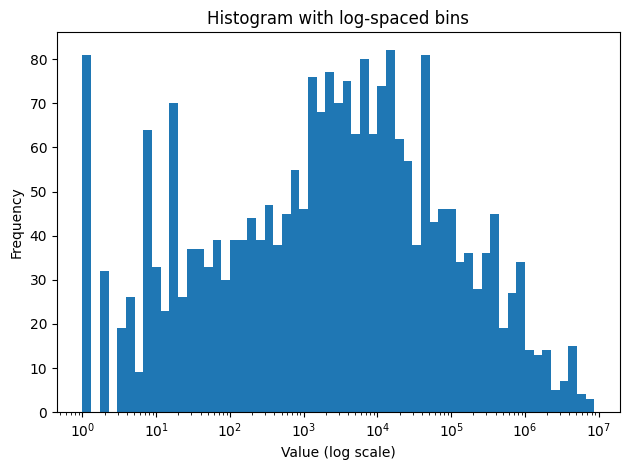

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# summary statistics
s = pd.Series(count_list)
summary = pd.DataFrame({
    "count": [s.size],
    "unique": [s.nunique()],
    "min": [s.min()],
    "p1": [s.quantile(0.01)],
    "p5": [s.quantile(0.05)],
    "p25": [s.quantile(0.25)],
    "median": [s.median()],
    "p75": [s.quantile(0.75)],
    "p95": [s.quantile(0.95)],
    "p99": [s.quantile(0.99)],
    "max": [s.max()]
})
print(summary.to_string(index=False))

# log-spaced bins
b = np.logspace(np.log10(min(count_list)), np.log10(max(count_list)), 60)
plt.figure()
plt.hist(count_list, bins=b)
plt.xscale('log')
plt.xlabel("Value (log scale)")
plt.ylabel("Frequency")
plt.title("Histogram with log-spaced bins")
plt.tight_layout()
plt.show()

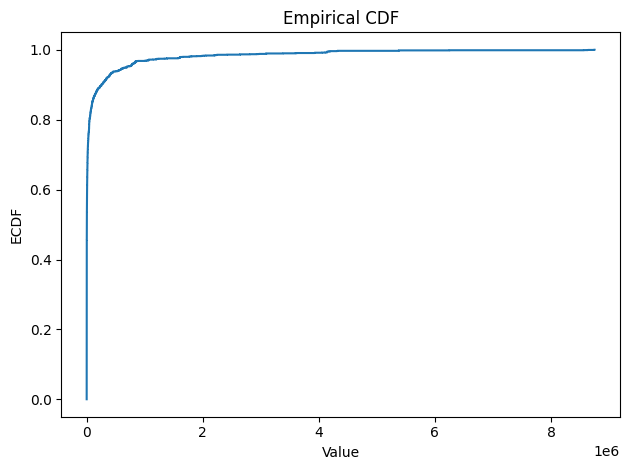

In [22]:
x = np.sort(count_list)
y = np.arange(1, x.size + 1) / x.size
plt.figure()
plt.plot(x, y, drawstyle="steps-post")
plt.xlabel("Value")
plt.ylabel("ECDF")
plt.title("Empirical CDF")
plt.tight_layout()
plt.show()

### Tokenizer

In [2]:
import femr.models.tokenizer
import pickle
tokenizer_path = "/user/zj2398/cache/motor_mimic/tokenizer"
ontology_path = "/user/zj2398/cache/motor_mimic/ontology.pkl"
with open(ontology_path, 'rb') as f:
    ontology = pickle.load(f)
tokenizer = femr.models.tokenizer.HierarchicalTokenizer.from_pretrained(tokenizer_path, ontology=ontology)
print(tokenizer.dictionary.keys())

dict_keys(['vocab', 'age_stats'])


In [3]:
# import json
# store_path = "/user/zj2398/cache/motor/tokenizer"
# with open("dictionary.json", "w", encoding="utf-8") as f:
#     json.dump(tokenizer.dictionary, f)
# print(len(tokenizer.dictionary['vocab']))
print(tokenizer.numeric_values)
print(tokenizer.numeric_indices)

{'doses_per_24_hrs': [1.0, 2.0], 'drg_mortality': [], 'drg_severity': [], 'emar_seq': [30.0, 54.0, 82.0, 118.0, 163.0, 214.0, 275.0, 355.0, 434.0, 525.0, 657.0, 797.0, 936.0, 1075.0, 1217.5, 1383.0, 1775.5], 'hadm_id': [20600184.0, 20642640.0, 21086876.0, 21738619.0, 22148160.0, 22595853.0, 22841357.0, 22927623.0, 23052089.0, 23280645.0, 24558333.0, 24947999.0, 24955974.0, 25242409.0, 25742920.0, 25849114.0, 25860671.0, 26082811.0, 26146595.0, 26381316.0, 26504700.0, 26913865.0, 27250926.0, 27880650.0, 27897940.0, 27988844.0, 28289260.0, 28328117.0, 28979390.0, 29079034.0, 29541074.0, 29654838.0, 29888819.0], 'icustay_id': [31205490.0, 34592300.0, 37067082.0, 37081114.0, 37510196.0, 39553978.0, 39698942.0, 39765666.0], 'link_order_id': [622572.375, 1182171.0, 1798033.375, 2459553.0, 2967077.0, 3640000.0, 4183202.0, 4796653.0, 5423638.0, 6059242.0, 6599459.25, 7260953.0, 7913756.0, 8595869.0, 9357883.0], 'numeric_value': [0.0, 0.03411764706320617, 0.10000000149011612, 0.2000000029802322

In [13]:
import pickle
from femr.models.tokenizer.hierarchical_tokenizer import HierarchicalTokenizer
import pathlib
import meds_reader
meds_reader_path = "/data/processed_datasets/processed_datasets/ehr_foundation_data/ohdsi_cumc_deid/ohdsi_cumc_deid_2023q4r3_v3_mapped/post_transform_meds_reader"
database = meds_reader.SubjectDatabase(meds_reader_path)

pretraining_data_path = pathlib.Path("/data/processed_datasets/processed_datasets/zj2398/femr/cumc/motor_cumc_bin_8/")
task_path = pretraining_data_path / "motor_task.pkl"
with open(task_path, 'rb') as f:
    motor_task = pickle.load(f)
task_info = motor_task.pretraining_task_info
list_task_info = list(i[0] for i in task_info)
# print(list_task_info)
for event in database["2727631"].events:
    if event.code in list_task_info:
        print(event)


ontology_path = pretraining_data_path / 'ontology.pkl'
tokenizer_path = pretraining_data_path / 'tokenizer'
with open(ontology_path, 'rb') as f:
    ontology = pickle.load(f)
tokenizer = HierarchicalTokenizer.from_pretrained(tokenizer_path, ontology=ontology)

Event(time=1995-05-31 13:42:00, code=PCORNet/Generic-NI, ...)
Event(time=1995-05-31 13:42:00, code=Visit/OP, ...)


In [ ]:
for event in database["2727631"].events:
    if event.code in tokenizer.code_lookup:
        print(event)

Event(time=1994-05-09 00:00:00, code=Ethnicity/Unknown, ...)
Event(time=1994-05-09 00:00:00, code=Gender/F, ...)
Event(time=1994-05-09 00:00:00, code=MEDS_BIRTH, ...)
Event(time=1994-05-09 00:00:00, code=Race/UNK, ...)
Event(time=1995-05-31 13:42:00, code=ICD10CM/I10.00, ...)
Event(time=1995-05-31 13:42:00, code=PCORNet/Generic-NI, ...)
Event(time=1995-05-31 13:42:00, code=Visit/OP, ...)
Event(time=1995-05-31 14:00:00.156749, code=LOINC/4537-7//UCUM/mm/h, ...)


: 

In [8]:
import femr.models.tokenizer
print(tokenizer.string_lookup['unit'])
print(len(tokenizer.string_lookup['unit'])) 
# ['route', 'frequency', 'text_value', 'language', 'race', 'priority', 'marital_status', 'insurance', 'unit', 'statusdescription', 'ordercategorydescription']


{'mL': 622, 'mL/hour': 650, 'mg': 735, 'dose': 757, 'grams': 934, 'mcg/kg/min': 963, 'units': 991, 'mEq': 1150, 'units/hour': 1382, 'mcg': 1385, 'mg/hour': 1777, 'mcg/hour': 1908, 'mg/min': 1934, 'mmol': 2382, 'mcg/kg/hour': 2724, 'grams/hour': 4996, 'mg/kg/hour': 5066, 'mEq.': 5636, 'mEq./hour': 5637, 'grams/min': 11161}
20


In [5]:
# a = list(tokenizer.code_lookup.keys())
# # print(len(a))
# print(a)
print(tokenizer.code_lookup)

{'MEDS_BIRTH': 265, 'ED_OUT': 266, 'ED_REGISTRATION': 267, 'LAB//51516//#/hpf': 268, 'LAB//51476//#/hpf': 269, 'LAB//51493//#/hpf': 270, 'MEDICATION//STOP//Sodium Chloride 0.9%  Flush': 271, 'MEDICATION//START//Sodium Chloride 0.9%  Flush': 272, 'LAB//50885//mg/dL': 274, 'LAB//52172//fL': 275, 'LAB//51249//g/dL': 276, 'LAB//50863//IU/L': 277, 'LAB//51275//sec': 278, 'LAB//51249//%': 280, 'GENDER//F': 281, 'GENDER//M': 282, 'LAB//50933//UNK': 286, 'MEDICATION//START//Acetaminophen': 287, 'MEDICATION//STOP//Acetaminophen': 288, 'LAB//50887//UNK': 290, 'LAB//51274//sec': 292, 'LAB//51237//UNK': 293, 'Weight (Lbs)': 295, 'Blood Pressure': 296, 'LAB//50862//g/dL': 297, 'LAB//50878//IU/L': 299, 'LAB//51506//UNK': 300, 'LAB//51508//UNK': 301, 'LAB//51466//UNK': 302, 'LAB//51486//UNK': 303, 'LAB//51487//UNK': 304, 'LAB//50970//mg/dL': 305, 'LAB//51464//mg/dL': 306, 'LAB//52075//K/uL': 307, 'LAB//52073//K/uL': 308, 'LAB//51133//K/uL': 309, 'LAB//52074//K/uL': 310, 'LAB//52069//K/uL': 311, 'LAB/

### Motor_task

In [ ]:
import pickle
task_path = '/user/zj2398/cache/motor/motor_task.pkl'
with open(task_path, 'rb') as f:
    motor_task = pickle.load(f)
print(motor_task.time_bins)
a = motor_task.pretraining_task_info

In [ ]:
print(a[0])

In [ ]:
# meds_reader_convert mimic_meds mimic_meds_reader --num_threads 32
import os
import pandas as pd
base_path = "/user/zj2398/cache/mimic/mimic-3.1-meds/patient_outcome_tasks/task"
for dir in os.listdir(base_path):
    dir_path = os.path.join(base_path, dir)
    if os.path.isdir(dir_path):
        parquet_file = os.path.join(dir_path, f"{dir}.parquet")
        if os.path.exists(parquet_file):
        #     print(f"The parquet file {parquet_file} exists")
        # else:
            # df = pd.concat([df_train, df_tuning, df_test])
            # df = df.sort_values(by=["subject_id", "prediction_time"])
            # df.to_parquet(parquet_file)
            # df_train.to_parquet(os.path.join(dir_path, f"{dir}.parquet"))
            # df_val.to_parquet(os.path.join(dir_path, f"{dir}.parquet"))
            # df_test.to_parquet(os.path.join(dir_path, f"{dir}.parquet"))
    # if os.path.isdir(os.path.join(base_path, dir)):
    # print(dir)

In [ ]:
import pandas as pd
dir_path = "/user/zj2398/cache/mimic/mimic-3.1-meds/patient_outcome_tasks/task/long_los/tuning.parquet"
df = pd.read_parquet(dir_path)
print(df)
df2 = df.to_dict(orient="records")
print(df2)

In [ ]:
print(df2[0:5])

In [10]:
import pickle
task_path = "/user/zj2398/cache/motor_mimic/motor_task.pkl"
with open(task_path, 'rb') as f:
    motor_task = pickle.load(f)
# print(motor_task.pretraining_task_codes)
code_dict = {}
for i in motor_task.pretraining_task_codes:
    code_type = i.split("//")[0]
    if code_type not in code_dict:
        code_dict[code_type] = 1
    else:
        code_dict[code_type] += 1
print(len(motor_task.pretraining_task_codes))
for i in code_dict:
    print(i, code_dict[i])

# print(motor_task.time_bins)
# print(motor_task.final_layer_size)


6100
MEDICATION 2757
PROCEDURE 460
INFUSION_START 106
DIAGNOSIS 1828
LAB 360
DRG 421
HOSPITAL_ADMISSION 39
TRANSFER_TO 81
ED_REGISTRATION 1
ICU_ADMISSION 9
ED_OUT 1
ICU_DISCHARGE 9
HOSPITAL_DISCHARGE 13
HCPCS 14
MEDS_DEATH 1


In [5]:
import torch
# a = torch.tensor([
#   # pred point 0
#   [[True, False, False],    # bin 0
#    [False, False, False]],  # bin 1

#   # pred point 1
#   [[False, False, False],
#    [False, False, True]]
# ])
# a = torch.tensor([[[0.4906, 0.0603, 0.3938, 0.1182],
#          [0.8817, 0.2784, 0.2033, 0.4675],
#          [0.0389, 0.5167, 0.3233, 0.8253]],

#         [[0.5043, 0.1975, 0.6027, 0.8749],
#          [0.4877, 0.4640, 0.9564, 0.4848],
#          [0.4997, 0.4962, 0.2766, 0.7736]]])
# a = torch.randint(0, 2, (2, 3, 4), dtype=torch.bool)
b= torch.tensor([[[ True, False, False,  True],
         [ True, False,  True,  True],
         [ True, False,  True,  True]],

        [[False,  True,  True,  True],
         [ True,  True, False, False],
         [False,  True, False,  True]]])
c = torch.any(b, dim=1)
print(c)

tensor([[ True, False,  True,  True],
        [ True,  True,  True,  True]])
